## Assignment 3

In [ ]:
%pip install pymc pytensor

In [ ]:
import pymc as pm

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression #for standard linear regression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler



### California Housing Dataset

In [ ]:
# Load California housing data
housing = fetch_california_housing()
X, y = housing.data, housing.target

In [ ]:
housing

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#X_train_scaled = X_train
#X_test_scaled = X_test

In [ ]:
print(np.shape(X_test))

(4128, 8)


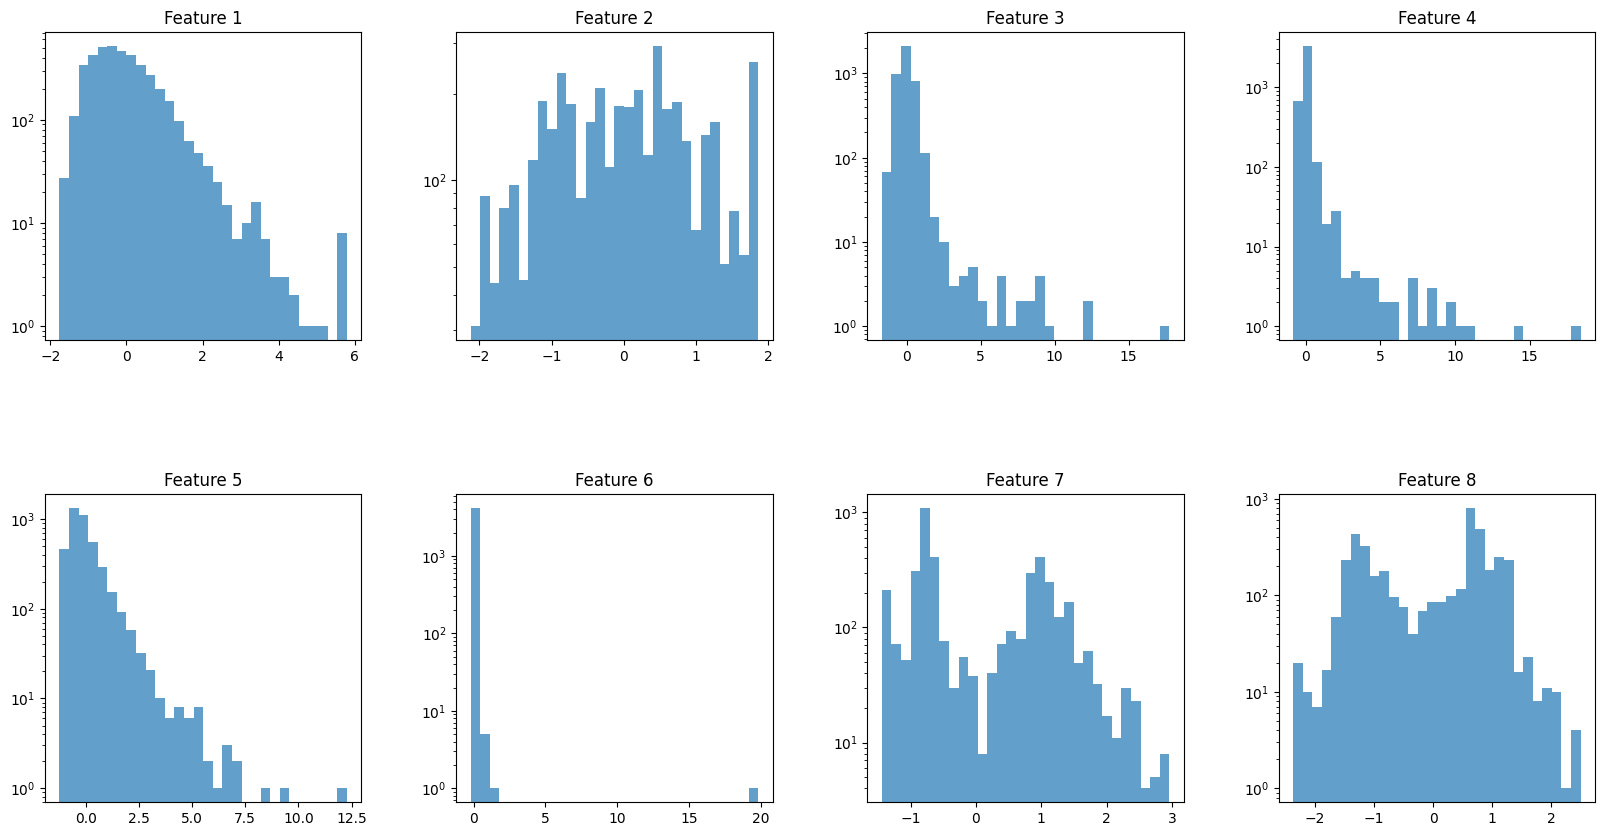

In [ ]:
import matplotlib.pyplot as plt

# Assuming X_test is defined and has the shape (4128, 8)

# Set up the matplotlib figure
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))  # Adjust size as needed
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between plots as needed

# Iterate over all features (columns) in X_test
for i in range(8):
    # Determine the position of the subplot
    row = i // 4
    col = i % 4
    ax = axs[row, col]

    # Plot the histogram for the i-th feature
    ax.hist(X_test_scaled[:, i], bins=30, alpha=0.7, log=True)
    ax.set_title(f'Feature {i+1}')

# Display the plot
plt.show()


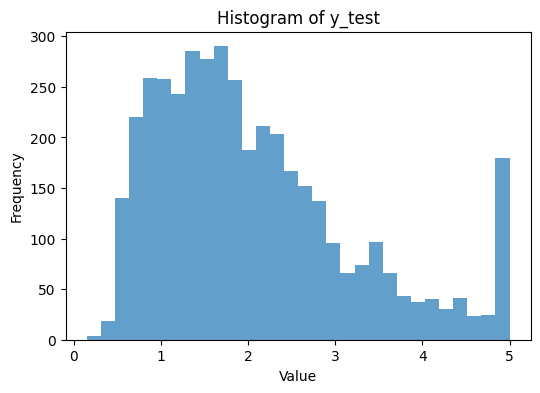

In [ ]:
# Plotting the histogram for y_test
plt.figure(figsize=(6, 4))  # Adjust figure size as needed
plt.hist(y_test.ravel(), bins=30, alpha=0.7)  # Use .ravel() to flatten y_test to 1D
plt.title('Histogram of y_test')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### Linear Regression

In [ ]:
# Initialize and train a linear regression model on the scaled data
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Predict on the scaled training set and the scaled test set
y_train_pred = lin_reg.predict(X_train_scaled)
y_test_pred = lin_reg.predict(X_test_scaled)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f'Training Mean Squared Error: {train_mse:.4f}')
print(f'Test Mean Squared Error: {test_mse:.4f}')

# Coefficients and Intercept
print('Intercept:', lin_reg.intercept_)
print('Coefficients:', lin_reg.coef_)

Training Mean Squared Error: 0.5179
Test Mean Squared Error: 0.5559
Intercept: 2.071946937378619
Coefficients: [ 0.85438303  0.12254624 -0.29441013  0.33925949 -0.00230772 -0.0408291
 -0.89692888 -0.86984178]


In [ ]:
# without scaling

#Training Mean Squared Error: 0.5179
#Test Mean Squared Error: 0.5559
#Intercept: -37.02327770606391
#Coefficients: [ 4.48674910e-01  9.72425752e-03 -1.23323343e-01  7.83144907e-01  -2.02962058e-06 -3.52631849e-03 -4.19792487e-01 -4.33708065e-01]

### Bayesian Linear Regression with PyMC

In [ ]:
# Define the model
with pm.Model() as model_lin:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X_train.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + pm.math.dot(X_train_scaled, beta)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_train)

    # Sample from the posterior
    idata_lin = pm.sample(500, chains=1) # lengthy: use burn-in of 1000 and 1000 draws for 1 chain


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

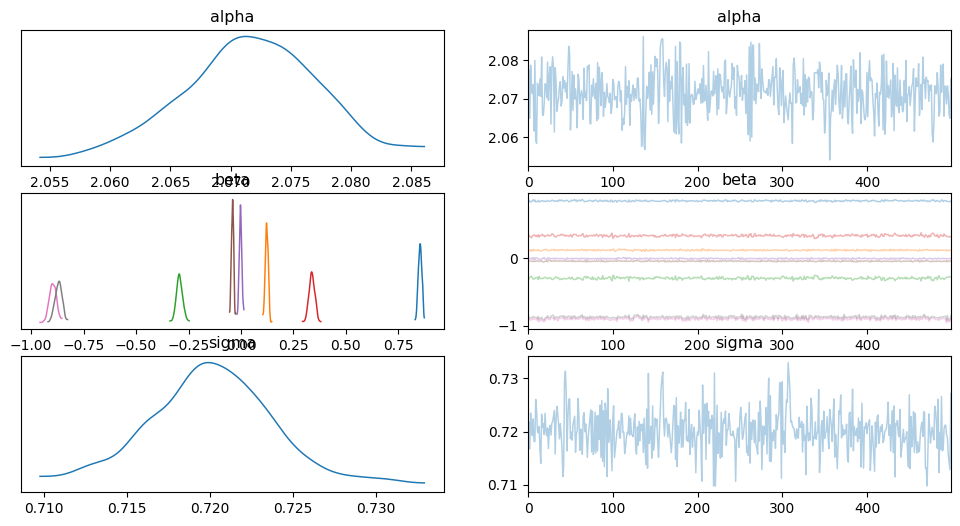

In [ ]:
import arviz as az
az.plot_trace(idata_lin)

In [ ]:
pos_alpha = idata_lin.posterior['alpha'].mean(axis=0).values
pos_betas = idata_lin.posterior['beta'].mean(axis=0).values

#print(np.shape(pos_alpha))
print(np.shape(pos_betas))


#pos_alpha = pos_alpha.reshape((np.shape(pos_alpha)[1],))

#pos_betas = pos_betas.reshape((np.shape(pos_betas)[1],np.shape(pos_betas)[2]))


(500, 8)
(500,) (500, 8) (8, 4128)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
pos_y_test = pos_alpha[:, np.newaxis] + np.dot(pos_betas, X_test_scaled.T)
pos_y_train = pos_alpha[:, np.newaxis] + np.dot(pos_betas, X_train_scaled.T)

print(np.shape(pos_y_test), type(pos_y_test))

pos_y_test_mean = np.mean(pos_y_test, axis=0)
pos_y_train_mean = np.mean(pos_y_train, axis=0)

print(np.shape(pos_y_test_mean))

pos_y_test_lower = np.percentile(pos_y_test,3, axis=0)
pos_y_test_upper = np.percentile(pos_y_test,97, axis=0)
pos_y_train_lower = np.percentile(pos_y_train,3, axis=0)
pos_y_train_upper = np.percentile(pos_y_train,97, axis=0)
print(np.shape(pos_y_test_lower))

for i in range(len(y_test)):
  if(i%50==0):
    print(f"true: {y_test[i]:1.4f}, y_test_pred: {y_test_pred[i]:1.4f}, Bayes mean: {pos_y_test_mean[i]:1.4f}, range: ({pos_y_test_lower[i]:1.4f}, {pos_y_test_upper[i]:1.4f})")

(500, 4128) <class 'numpy.ndarray'>
(4128,)
(4128,)
true: 0.7100, y_test_pred: 0.7191, Bayes mean: 0.8282, range: (0.7996, 0.8556)
true: 1.8800, y_test_pred: 2.4037, Bayes mean: 2.5199, range: (2.5014, 2.5369)
true: 2.2940, y_test_pred: 1.5178, Bayes mean: 2.5583, range: (2.5374, 2.5781)
true: 1.5630, y_test_pred: 1.5097, Bayes mean: 2.1514, range: (2.1311, 2.1708)
true: 1.9640, y_test_pred: 2.3937, Bayes mean: 2.2789, range: (2.2600, 2.2955)
true: 0.7020, y_test_pred: 1.0502, Bayes mean: 0.6899, range: (0.6695, 0.7124)
true: 1.8310, y_test_pred: 0.6687, Bayes mean: 2.2953, range: (2.2688, 2.3216)
true: 1.1610, y_test_pred: 1.4168, Bayes mean: 1.5943, range: (1.5747, 1.6132)
true: 1.7710, y_test_pred: 2.5336, Bayes mean: 2.3466, range: (2.3202, 2.3735)
true: 4.3930, y_test_pred: 2.8634, Bayes mean: 2.7801, range: (2.7474, 2.8080)
true: 2.6050, y_test_pred: 2.2113, Bayes mean: 2.4015, range: (2.3789, 2.4223)
true: 2.9520, y_test_pred: 0.9937, Bayes mean: 2.1671, range: (2.1510, 2.1836)


In [ ]:
#--- comparing Linear Regression with Bayesian Linear Regression

print("LINEAR REGRESSION")
print(f'Training Mean Squared Error: {train_mse:.4f}')
print(f'Test Mean Squared Error: {test_mse:.4f}')
print("\n")

# Evaluate the model
train_mse_bayes = mean_squared_error(y_train, pos_y_train_mean)
test_mse_bayes  = mean_squared_error(y_test, pos_y_test_mean)

print("BAYESIAN LINEAR REGRESSION")
print(f'Training Mean Squared Error: {train_mse_bayes:.4f}')
print(f'Test Mean Squared Error: {test_mse_bayes:.4f}')


LINEAR REGRESSION
Training Mean Squared Error: 0.5179
Test Mean Squared Error: 0.5559


BAYESIAN LINEAR REGRESSION
Training Mean Squared Error: 0.5212
Test Mean Squared Error: 0.5418


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

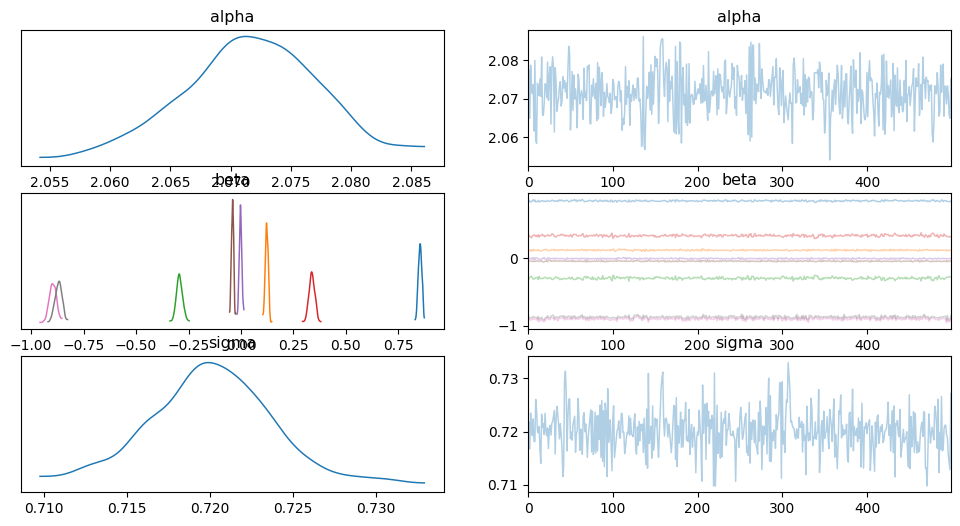

In [ ]:
az.plot_trace(idata_lin)

In [ ]:
az.summary(idata_pol)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.930,0.005,1.922,1.940,0.000,0.000,1249.0,839.0,1.00
beta[0],0.886,0.009,0.870,0.902,0.000,0.000,659.0,739.0,1.00
beta[1],0.113,0.005,0.102,0.122,0.000,0.000,1011.0,610.0,1.00
beta[2],-0.337,0.017,-0.368,-0.305,0.001,0.000,616.0,697.0,1.01
beta[3],0.400,0.017,0.367,0.433,0.001,0.000,732.0,417.0,1.01
beta[4],0.036,0.004,0.028,0.044,0.000,0.000,1289.0,741.0,1.01
beta[5],-2.814,0.077,-2.944,-2.649,0.002,0.001,1319.0,572.0,1.01
beta[6],-0.773,0.014,-0.796,-0.745,0.001,0.000,598.0,754.0,1.00
beta[7],-0.730,0.013,-0.757,-0.706,0.001,0.000,620.0,736.0,1.00
sigma,0.448,0.005,0.439,0.458,0.000,0.000,720.0,647.0,1.01


### Polynomial Linear regression

In [ ]:
# Define the model
with pm.Model() as model_pol:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X_train.shape[1])
    gamma = pm.Normal('gamma', mu=0, sigma=10, shape=X_train.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=1)

    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)

    # Expected value of outcome
    mu = alpha + pm.math.dot(X_train_scaled, beta) + pm.math.dot(X_train_scaled**2, gamma)

    # Likelihood (sampling distribution) of observations
    #Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_train)

    Y_obs = pm.StudentT('Y_obs', mu=mu, sigma=sigma, nu=ν, observed=y_train) #ϵ



    # Sample from the posterior
    idata_pol = pm.sample(500, chains=2) # lengthy: use burn-in of 1000 and 1000 draws for 1 chain

In [ ]:
az.summary(idata_pol)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.943,0.011,1.922,1.963,0.004,0.003,8.0,479.0,1.20
beta[0],0.868,0.013,0.844,0.891,0.005,0.004,6.0,189.0,1.30
beta[1],0.110,0.005,0.100,0.120,0.000,0.000,193.0,633.0,1.03
beta[2],-0.330,0.024,-0.373,-0.285,0.013,0.010,4.0,271.0,1.54
beta[3],0.480,0.030,0.429,0.532,0.017,0.013,4.0,91.0,1.61
beta[4],0.052,0.008,0.038,0.067,0.003,0.002,6.0,202.0,1.26
beta[5],-1.768,0.167,-1.993,-1.540,0.114,0.095,3.0,221.0,1.83
beta[6],-0.870,0.017,-0.903,-0.840,0.001,0.001,352.0,508.0,1.01
beta[7],-0.824,0.016,-0.854,-0.796,0.001,0.001,364.0,529.0,1.01
gamma[0],0.007,0.004,0.000,0.015,0.001,0.001,25.0,444.0,1.06


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'ν_'}>, <Axes: title={'center': 'ν_'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>]],
      dtype=object)

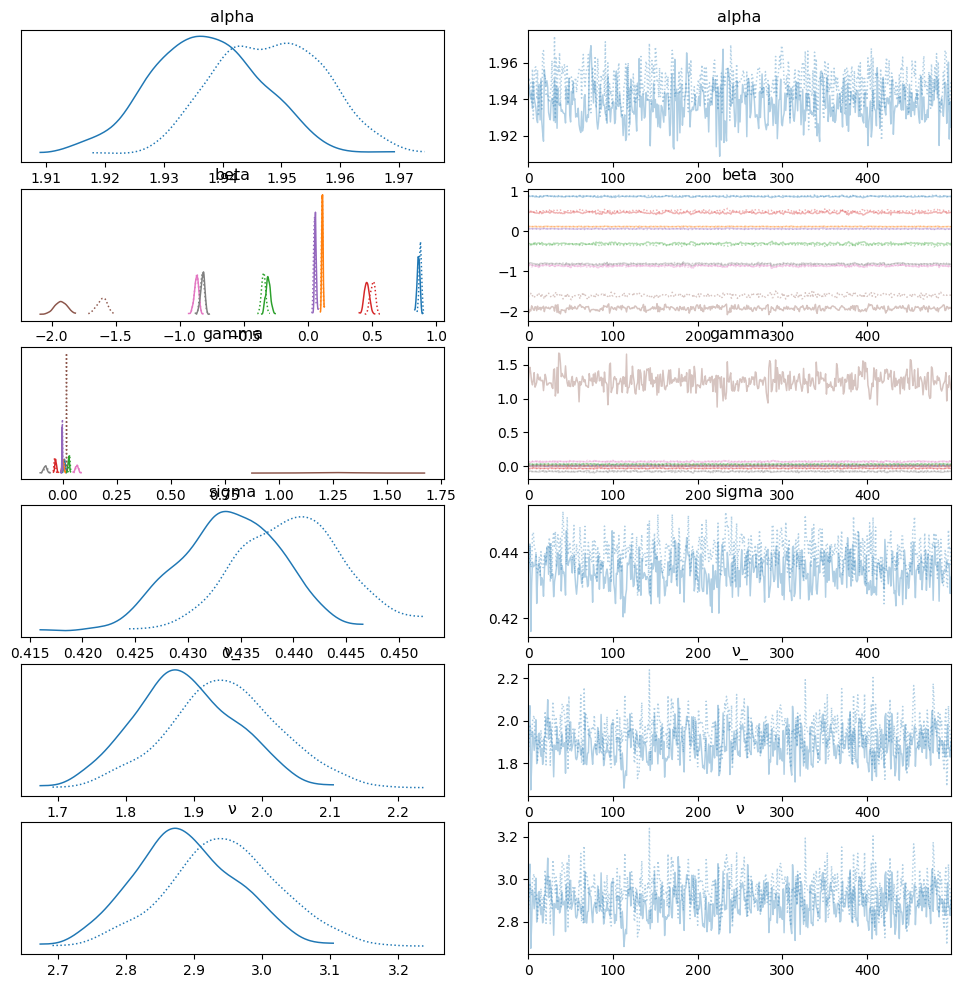

In [ ]:
az.plot_trace(idata_pol, compact=True)

In [ ]:
pos_alpha_pol = idata_pol.posterior['alpha'].mean(axis=0).values
pos_betas_pol = idata_pol.posterior['beta'].mean(axis=0).values
pos_gammas_pol = idata_pol.posterior['gamma'].mean(axis=0).values

pos_y_test_pol = pos_alpha_pol[:, np.newaxis] + np.dot(pos_betas_pol, X_test_scaled.T) + np.dot(pos_gammas_pol, (X_test_scaled**2).T)
pos_y_test_mean_pol = np.mean(pos_y_test_pol, axis=0)

pos_y_train_pol = pos_alpha_pol[:, np.newaxis] + np.dot(pos_betas_pol, X_train_scaled.T) + np.dot(pos_gammas_pol, (X_train_scaled**2).T)
pos_y_train_mean_pol = np.mean(pos_y_train_pol, axis=0)

pos_y_test_lower_pol = np.percentile(pos_y_test_pol,3, axis=0)
pos_y_test_upper_pol = np.percentile(pos_y_test_pol,97, axis=0)

pos_y_train_lower_pol = np.percentile(pos_y_train_pol,3, axis=0)
pos_y_train_upper_pol = np.percentile(pos_y_train_pol,97, axis=0)


for i in range(len(y_test)):
  if(i%50==0):
    print(f"true: {y_test[i]:1.4f}, y_test_pred: {y_test_pred[i]:1.4f}, Bayes mean: {pos_y_test_mean_pol[i]:1.4f}, range: ({pos_y_test_lower_pol[i]:1.4f}, {pos_y_test_upper_pol[i]:1.4f})")

true: 0.7100, y_test_pred: 0.7191, Bayes mean: 0.8540, range: (0.8388, 0.8722)
true: 1.8800, y_test_pred: 2.4037, Bayes mean: 2.0451, range: (2.0291, 2.0622)
true: 2.2940, y_test_pred: 1.5178, Bayes mean: 2.3091, range: (2.2954, 2.3226)
true: 1.5630, y_test_pred: 1.5097, Bayes mean: 2.0410, range: (2.0267, 2.0553)
true: 1.9640, y_test_pred: 2.3937, Bayes mean: 2.3225, range: (2.3085, 2.3389)
true: 0.7020, y_test_pred: 1.0502, Bayes mean: 0.7358, range: (0.7131, 0.7576)
true: 1.8310, y_test_pred: 0.6687, Bayes mean: 1.9189, range: (1.9022, 1.9385)
true: 1.1610, y_test_pred: 1.4168, Bayes mean: 1.5029, range: (1.4898, 1.5159)
true: 1.7710, y_test_pred: 2.5336, Bayes mean: 2.2480, range: (2.2301, 2.2658)
true: 4.3930, y_test_pred: 2.8634, Bayes mean: 3.0842, range: (3.0581, 3.1112)
true: 2.6050, y_test_pred: 2.2113, Bayes mean: 2.2908, range: (2.2762, 2.3061)
true: 2.9520, y_test_pred: 0.9937, Bayes mean: 2.3018, range: (2.2846, 2.3199)
true: 1.6770, y_test_pred: 1.4220, Bayes mean: 1.824

In [ ]:
#--- comparing Linear Regression with Polynomial Bayesian Linear Regression

print("LINEAR REGRESSION")
print(f'Training Mean Squared Error: {train_mse:.4f}')
print(f'Test Mean Squared Error: {test_mse:.4f}')
print("\n")

# Evaluate the model
train_mse_bayes_rob = mean_squared_error(y_train, pos_y_train_mean_rob)
test_mse_bayes_rob  = mean_squared_error(y_test, pos_y_test_mean_rob)

print("BAYESIAN LINEAR REGRESSION")
print(f'Training Mean Squared Error: {train_mse_bayes:.4f}')
print(f'Test Mean Squared Error: {test_mse_bayes:.4f}')
print("\n")

print("BAYESIAN POLYNOMIAL REGRESSION")
print(f'Training Mean Squared Error: {train_mse_bayes_rob:.4f}')
print(f'Test Mean Squared Error: {test_mse_bayes_rob:.4f}')


LINEAR REGRESSION
Training Mean Squared Error: 0.5179
Test Mean Squared Error: 0.5559


BAYESIAN LINEAR REGRESSION
Training Mean Squared Error: 0.5212
Test Mean Squared Error: 0.5418


BAYESIAN POLYNOMIAL REGRESSION
Training Mean Squared Error: 0.5231
Test Mean Squared Error: 0.5892


### Model Comparison

In [ ]:
#---------- Posterior Predictive Checks

In [ ]:
y_l = pm.sample_posterior_predictive(idata_lin,model=model_lin)

In [ ]:
y_p = pm.sample_posterior_predictive(idata_pol,model=model_pol)

In [ ]:
y_l

Inference data with groups:
	> posterior_predictive
	> observed_data

([], [])

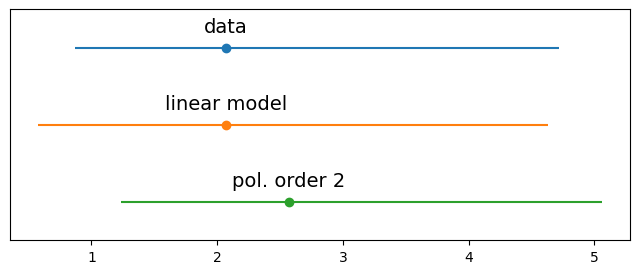

In [ ]:
plt.figure(figsize=(8,3))

y_o   = y_train
y_l  = y_l.posterior_predictive['Y_obs'].mean(axis=0).mean(axis=0).values
y_p  = y_p.posterior_predictive['y_pred'].mean(axis=0).mean(axis=0).values


data = [y_o, y_l, y_p]
labels = ['data', 'linear model', 'pol. order 2']

for i, d in enumerate(data):
  mean = d.mean()
  err = np.percentile(d, [25,75])
  plt.errorbar(mean,-i,xerr=[[err[0]],[err[1]]], fmt='o')
  plt.text(mean,-i+0.2, labels[i], ha='center', fontsize=14)

plt.ylim([-i-0.5,0.5])
plt.yticks([])

In [ ]:
#---------- Information Criteria

In [ ]:
with model_lin:
    pm.compute_log_likelihood(idata_lin)


with model_pol:
    pm.compute_log_likelihood(idata_pol)

In [ ]:
idata_pol

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [ ]:
df_compare = az.compare({"model_l": idata_lin, "model_p2": idata_pol}, ic='waic') #loo is recommended
df_compare

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
model_p2,0,-16378.827016,690.666675,0.000000,0.634616,394.119950,0.000000,True,log
model_l,1,-18016.084000,24.350585,1637.256984,0.365384,144.157057,420.237166,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_waic (log)', ylabel='ranked models'>

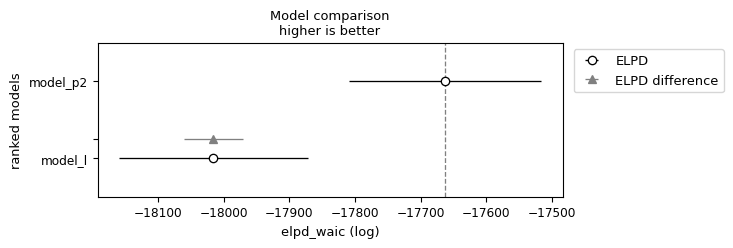

In [ ]:
az.plot_compare(df_compare, insample_dev=False)